# Sales Predictions

## Preparing Tools and Loading Data

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
df = pd.read_csv('/content/drive/My Drive/tensorflow/Data/TF_2_Notebooks_and_Data/DATA/RSCCASN.csv',
                 parse_dates=True,
                 index_col='DATE')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sales   334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [9]:
df.head()

,sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [0]:
df.columns = ['sales']

In [8]:
df.head()

,sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


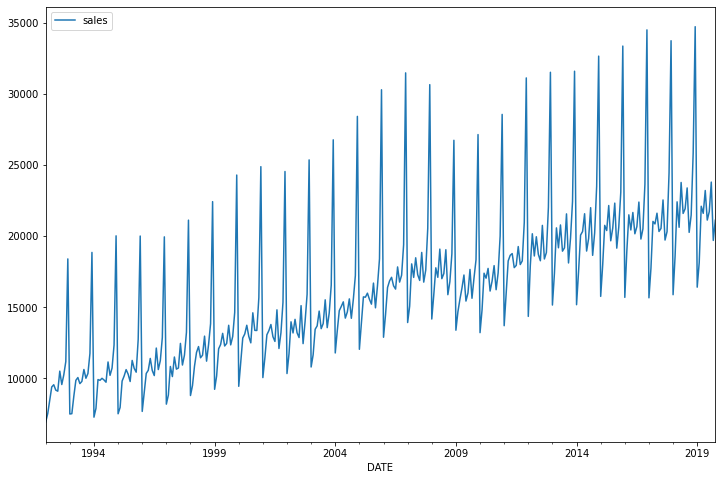

In [15]:
df.plot(figsize=(12,8));

## Splitting Data into Train and Test sets

In [16]:
len(df)

334

In [17]:
# 12 rows = 1 year /12 months
# 18 rows = 1.5 years
len(df) - 18

316

In [0]:
test_size = 18
test_index = len(df) - test_size

In [19]:
test_index

316

In [0]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [21]:
train

,sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [22]:
test

,sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [23]:
len(train), len(test)

(316, 18)

## Normalizing

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

## Creating TimeSeriesGeneartor

In [0]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

length = 12
batch_size = 1

generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length=length,
                                batch_size=batch_size)

In [0]:
X, y = generator[0]

In [37]:
len(X[0])

12

In [38]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [39]:
y

array([[0.02047633]])

## Modelling

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

n_features = 1 # we've only one feature i.e. previous sales data

model = Sequential()

model.add(LSTM(100, 
               activation='relu',
               input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam',
              loss='mse')

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


**Early Stopping Callback**

In [0]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',
                           patience=2)

In [0]:
validation_generator = TimeseriesGenerator(scaled_test,
                                           scaled_test,
                                           length=length,
                                           batch_size=batch_size)

In [62]:
model.fit_generator(generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0252 - val_loss: 0.0403
Epoch 2/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0169 - val_loss: 0.0500
Epoch 3/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0122 - val_loss: 0.0047
Epoch 4/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0072 - val_loss: 0.0180
Epoch 5/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 6/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0020 - val_loss: 4.6741e-04
Epoch 7/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0074
Epoch 8/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0019 - val_loss: 0.0035


In [63]:
losses = pd.DataFrame(model.history.history)
losses

,loss,val_loss
0,0.025250,0.040278
1,0.016871,0.049988
2,0.012230,0.004667
3,0.007237,0.017967
4,0.003040,0.003553
5,0.002035,0.000467
6,0.001307,0.007380
7,0.001903,0.003510


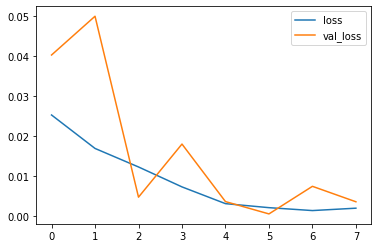

In [64]:
losses.plot()

## Evaluating

In [0]:
test_predictions = []

# grabbing last 12 months from training set to predict 1 month in future
first_eval_batch = scaled_train[-length:]

# reshaping into correct format that is required by the RNN
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [0]:
true_preds = scaler.inverse_transform(test_predictions)

In [67]:
len(true_preds)

18

In [68]:
test['Predictions'] = true_preds
test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,sales,Predictions
DATE,,
2018-05-01,23764,22658.004085
2018-06-01,21589,21550.518711
2018-07-01,21919,21817.096280
2018-08-01,23381,23741.357371
2018-09-01,20260,21247.351452
2018-10-01,21473,21880.897981
2018-11-01,25831,25941.951313
2018-12-01,34706,37837.809923
2019-01-01,16410,17472.772883


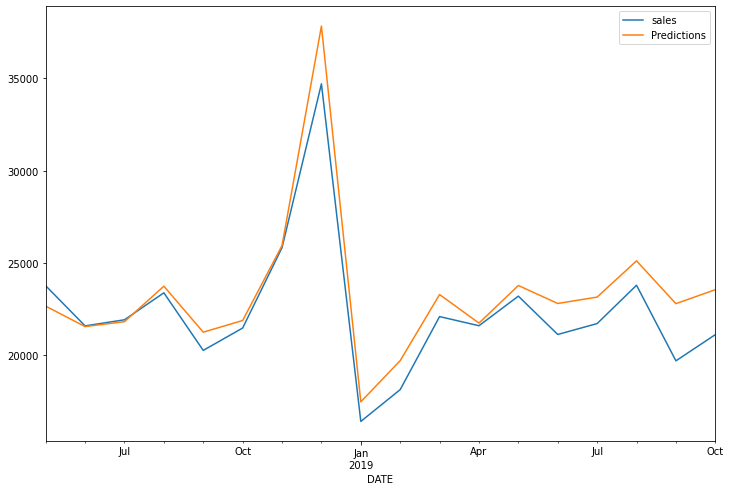

In [70]:
test.plot(figsize=(12,8));

## Forecasting Values of Future

### Normalizing Full Data

In [0]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [77]:
scaled_full_data[:5]

array([[0.        ],
       [0.02110343],
       [0.05535148],
       [0.08869922],
       [0.09435321]])

### Genearator 

In [0]:
length = 12
generator = TimeseriesGenerator(scaled_full_data,
                                scaled_full_data,
                                length=length,
                                batch_size=1,
                                )

### Modelling

In [81]:
model = Sequential()

model.add(LSTM(100, activation='relu',
          input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam',
              loss='mse')

model.fit_generator(generator,
                    epochs=6)

Epoch 1/6
322/322 [==============================] - 2s 5ms/step - loss: 0.0261
Epoch 2/6
322/322 [==============================] - 2s 5ms/step - loss: 0.0175
Epoch 3/6
322/322 [==============================] - 2s 5ms/step - loss: 0.0093
Epoch 4/6
322/322 [==============================] - 2s 5ms/step - loss: 0.0055
Epoch 5/6
322/322 [==============================] - 2s 5ms/step - loss: 0.0021
Epoch 6/6
322/322 [==============================] - 2s 5ms/step - loss: 0.0024


In [82]:
losses = pd.DataFrame(model.history.history)
losses

,loss
0,0.026075
1,0.017532
2,0.009279
3,0.005525
4,0.002130
5,0.002365


### Evaluating

In [0]:
forecast = []

periods = 12

# grabbing last 12 months from training set to predict 1 month in future
first_eval_batch = scaled_full_data[-length:]

# reshaping into correct format that is required by the RNN
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
  current_pred = model.predict(current_batch)[0]

  forecast.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [87]:
forecast

[array([0.7561412], dtype=float32),
 array([1.0995568], dtype=float32),
 array([0.47081503], dtype=float32),
 array([0.5232146], dtype=float32),
 array([0.64425087], dtype=float32),
 array([0.6329431], dtype=float32),
 array([0.68383133], dtype=float32),
 array([0.62396294], dtype=float32),
 array([0.6448608], dtype=float32),
 array([0.71208394], dtype=float32),
 array([0.5974145], dtype=float32),
 array([0.64711654], dtype=float32)]

In [88]:
forecast = scaler.inverse_transform(forecast)
forecast

array([[27765.15282059],
       [37224.1926012 ],
       [19906.12926126],
       [21349.42235374],
       [24683.24595642],
       [24371.78457499],
       [25773.45026684],
       [24124.43518591],
       [24700.04598761],
       [26551.63992596],
       [23393.18481064],
       [24762.17802906]])

In [89]:
test

,sales,Predictions
DATE,,
2018-05-01,23764,22658.004085
2018-06-01,21589,21550.518711
2018-07-01,21919,21817.096280
2018-08-01,23381,23741.357371
2018-09-01,20260,21247.351452
2018-10-01,21473,21880.897981
2018-11-01,25831,25941.951313
2018-12-01,34706,37837.809923
2019-01-01,16410,17472.772883


In [90]:
forecast_index = pd.date_range(start='2019-11-01',
                               periods=periods,
                               freq='MS')

forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [0]:
forecast_df = pd.DataFrame(data=forecast, 
                           index=forecast_index,
                           columns=['forecast'])

In [92]:
forecast_df

,forecast
2019-11-01,27765.152821
2019-12-01,37224.192601
2020-01-01,19906.129261
2020-02-01,21349.422354
2020-03-01,24683.245956
2020-04-01,24371.784575
2020-05-01,25773.450267
2020-06-01,24124.435186
2020-07-01,24700.045988
2020-08-01,26551.639926


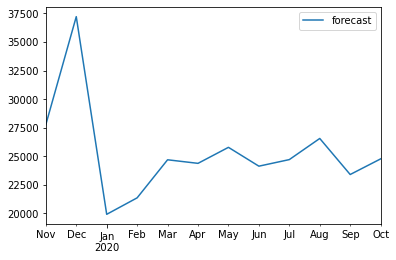

In [94]:
forecast_df.plot();

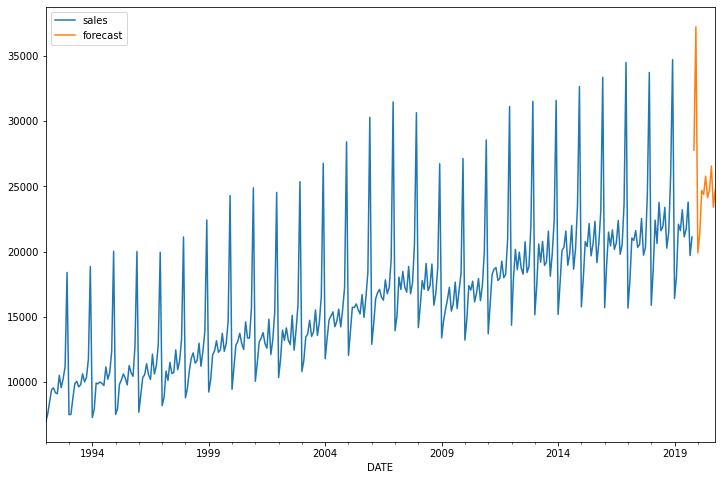

In [97]:
ax = df.plot()
forecast_df.plot(ax=ax,
                 figsize=(12,8));

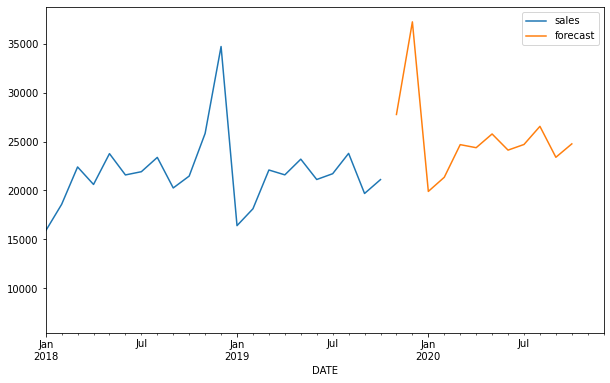

In [101]:
ax = df.plot()
forecast_df.plot(ax=ax,
                 figsize=(10,6));
plt.xlim('2018-01-01', '2020-12-01');